In [1]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATASET = "E:\Project\data"
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 8000


In [3]:
df_data = pd.read_csv(DATASET+'/train_labels.csv')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


In [4]:
 df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [5]:


def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()
    

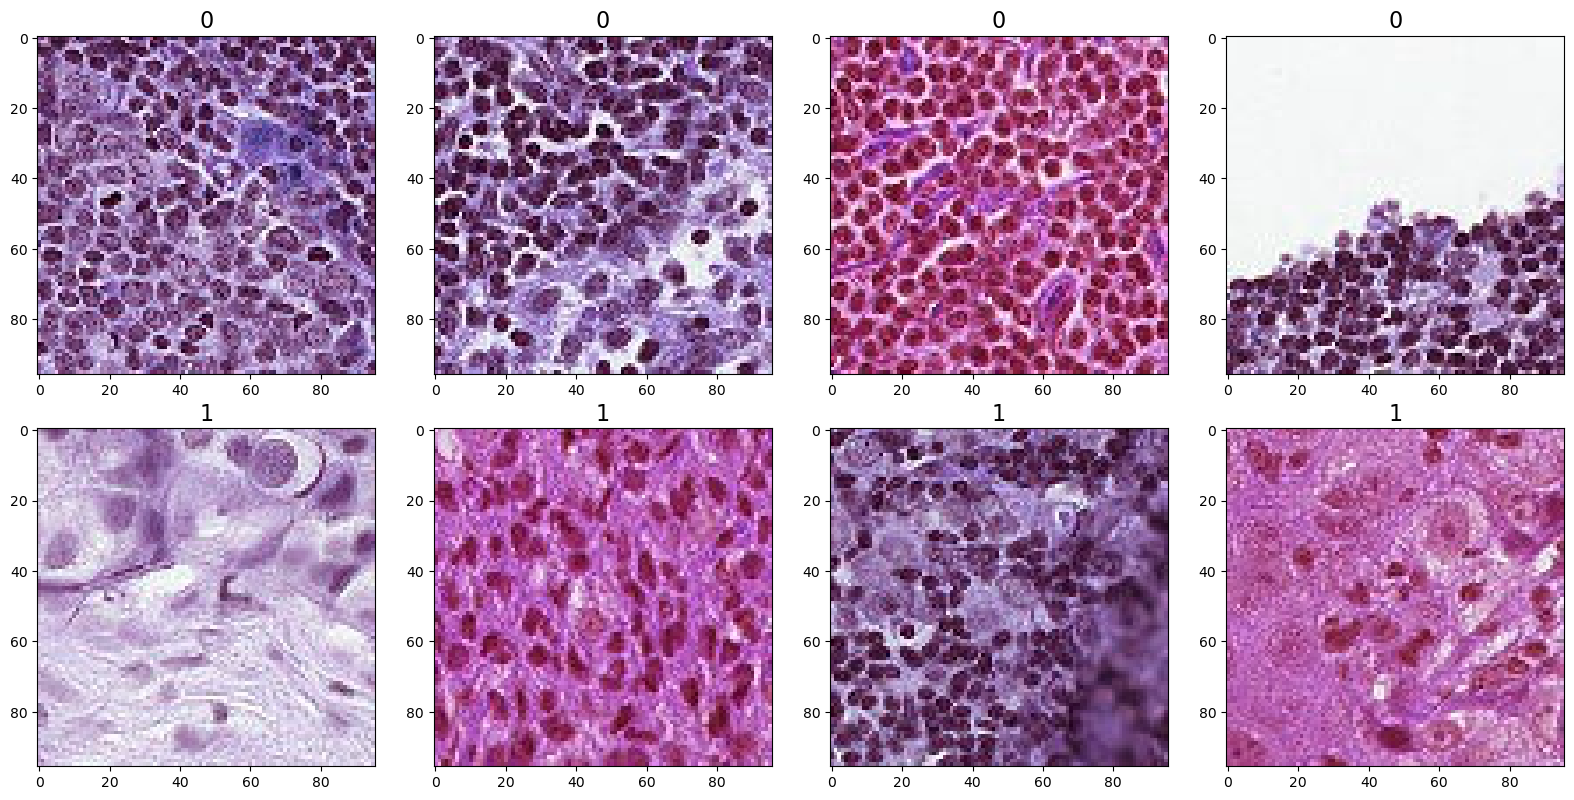

In [6]:
IMAGE_PATH = DATASET+'/train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

In [7]:
df_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

0    8000
1    8000
Name: label, dtype: int64

In [9]:
df_data.head()

,id,label
3706,567c722102098d5de7fbd1292d63347819a01585,0
11580,c9655cdcc5aee34bd5a9378ca6d63dd58de69a8e,1
6659,e42582d208d8c0133ab109a69de03d0f0be35cea,0
3027,030c031c9182bc3f86148b798b4a3d8db8db1ba5,0
719,6da6a4e96c00186956fdcc33cb6b8e6775e66025,0


In [10]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(14400, 2)
(1600, 2)


In [11]:
df_train['label'].value_counts()

0    7200
1    7200
Name: label, dtype: int64

In [12]:
df_val['label'].value_counts()

0    800
1    800
Name: label, dtype: int64

In [13]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)



In [14]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

In [15]:
df_data

,id,label
3706,567c722102098d5de7fbd1292d63347819a01585,0
11580,c9655cdcc5aee34bd5a9378ca6d63dd58de69a8e,1
6659,e42582d208d8c0133ab109a69de03d0f0be35cea,0
3027,030c031c9182bc3f86148b798b4a3d8db8db1ba5,0
719,6da6a4e96c00186956fdcc33cb6b8e6775e66025,0
...,...,...
11474,7334d3ac28b82b1a07ceccd6059e18676c22251a,1
2769,9483ad53a5242f75b6f31e3287a4f505c4343b9c,0
4255,56362b42e7e9b95e1a77ad184f158a629c9e650e,0
10003,6e7b1755a2c1948521d65187249590ad6d917d3c,1


In [16]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [17]:


# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join(DATASET+'\\train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join(DATASET+'\\train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    

In [18]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))


7200
7200


In [19]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))


800
800


In [20]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [21]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')
# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 14400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [22]:


kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [2]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

NameError: name 'model' is not defined

In [3]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

NameError: name 'val_gen' is not defined

In [23]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

C:\Users\tarun\AppData\Local\Temp\ipykernel_5256\4098454996.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [24]:
# get the metric names so we can use evaulate_generator
model.metrics_names

[]

In [25]:
# Here the best epoch will be used.

model.load_weights(DATASET+'/../model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

C:\Users\tarun\AppData\Local\Temp\ipykernel_5256\3080324843.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen,


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [26]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

C:\Users\tarun\AppData\Local\Temp\ipykernel_5256\2435426349.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


1600/1600 [==============================] - 28s 15ms/step


In [27]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [28]:

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.587169,0.412831
1,0.776821,0.223179
2,0.346711,0.653289
3,0.415101,0.584899
4,0.504960,0.495040


In [29]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']


In [30]:
###AUC Score

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.85360625

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [33]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [34]:
test_labels.shape

(1600,)

In [35]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [36]:
# Print the label associated with each class
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

Confusion matrix, without normalization
[[320 480]
 [ 35 765]]


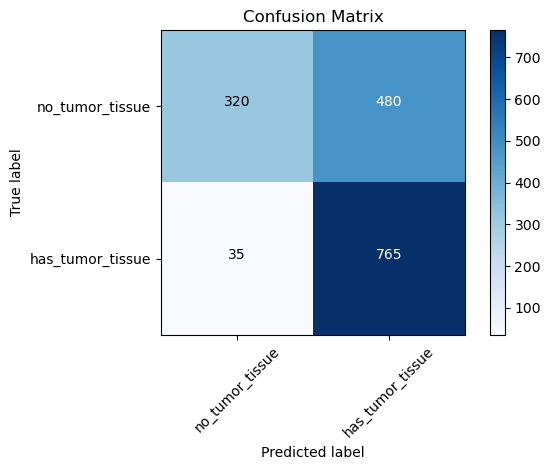

In [37]:

cm_plot_labels = ['no_tumor_tissue', 'has_tumor_tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [38]:
from sklearn.metrics import classification_report

y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)


                  precision    recall  f1-score   support

 no_tumor_tissue       0.90      0.40      0.55       800
has_tumor_tissue       0.61      0.96      0.75       800

        accuracy                           0.68      1600
       macro avg       0.76      0.68      0.65      1600
    weighted avg       0.76      0.68      0.65      1600



In [39]:
# deleting the base_dir File
if os.path.isdir(base_dir):
    shutil.rmtree('base_dir')


In [40]:
# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [41]:
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [ ]:
# Transfer the test images into image_dir

test_list = os.listdir(DATASET+'\\test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join(DATASET+'\\test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    

In [48]:
len(os.listdir('test_dir/test_images'))

57458

In [49]:
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [ ]:
num_test_images = len(os.listdir('test_dir/test_images'))

# make sure we are using the best epoch
model.load_weights('model.h5')

predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)


In [51]:
import pandas as pd

In [52]:
len(predictions)

57458

In [53]:
# Put the predictions into a dataframe
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

len(df_preds)

57458

In [54]:
test_filenames = test_gen.filenames
print(len(test_filenames))

df_preds['file_names'] = test_filenames

df_preds.head()

57458


,no_tumor_tissue,has_tumor_tissue,file_names
0,0.139759,0.860241,test_images\00006537328c33e284c973d7b39d340809...
1,0.150651,0.849349,test_images\0000ec92553fda4ce39889f9226ace43ca...
2,0.253819,0.746181,test_images\00024a6dee61f12f7856b0fc6be20bc7a4...
3,0.116012,0.883988,test_images\000253dfaa0be9d0d100283b22284ab2f6...
4,0.794687,0.205313,test_images\000270442cc15af719583a8172c87cd2bd...


In [55]:
def extract_id(x):
    # split into a list
    a = x.split('\\')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,0.139759,0.860241,test_images\00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.150651,0.849349,test_images\0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.253819,0.746181,test_images\00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.116012,0.883988,test_images\000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.794687,0.205313,test_images\000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [56]:

y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

In [57]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          })

submission.to_csv('patch_preds.csv') 

In [58]:
submission.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.860241
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.849349
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.746181
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.883988
4,000270442cc15af719583a8172c87cd2bd9c7746,0.205313


In [59]:
import warnings 
warnings.filterwarnings('ignore')
if os.path.isdir(test_dir):
    shutil.rmtree('test_dir')

In [60]:
submission['stages']=1
for i in range(len(submission['stages'])):
    if submission['label'][i]<0.25:
        submission['stages'][i]='normal'
    elif submission['label'][i] >0.25 and submission['label'][i]<0.5:
        submission['stages'][i]='Stage 1'
    elif submission['label'][i] >0.5 and submission['label'][i]<0.75:
        submission['stages'][i]='Stage 2'
    else:
        submission['stages'][i]='Critical'

In [61]:
submission['stages'].value_counts()

Critical    29927
Stage 2     12386
Stage 1      9687
normal       5458
Name: stages, dtype: int64

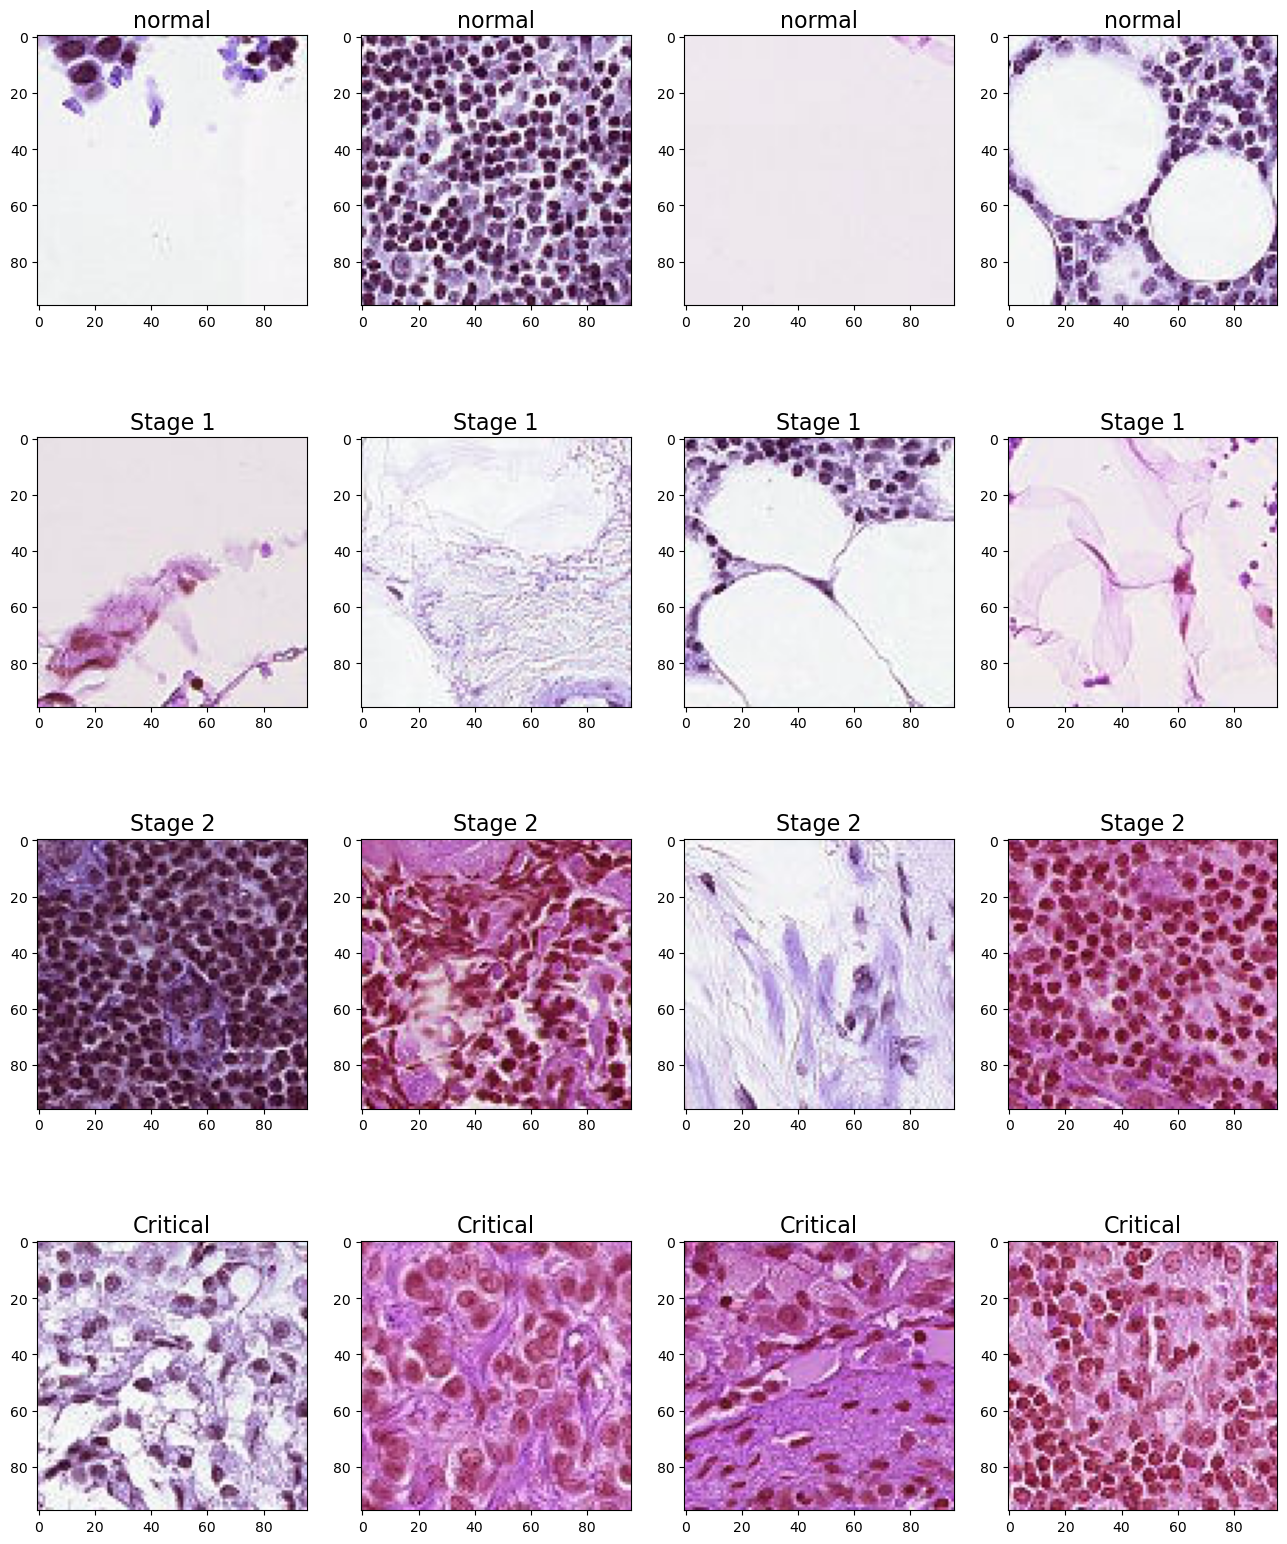

In [62]:
f, ax = plt.subplots(nrows=4,ncols=4,figsize=(16,20))
categories=['normal','Stage 1','Stage 2','Critical']
for i ,cat in enumerate(categories):
    sample=submission[submission['stages'] == cat].sample(4)
    for j in range(0,4):
        file=DATASET+'/test/'+sample.iloc[j]['id']+'.tif'
        #print(file)
        image=cv2.imread(file)
        #print(type(image))
        plt.imshow(image)
        ax[i,j].imshow(image,resample=True,cmap='gray')
        ax[i,j].set_title(cat,fontsize=16)
                      
plt.show()